### **Content License Agreement**

<font color='red'><b>**WARNING**</b></font> : 본 자료는 삼성청년SW·AI아카데미의 컨텐츠 자산으로, 보안서약서에 의거하여 어떠한 사유로도 임의로 복사, 촬영, 녹음, 복제, 보관, 전송하거나 허가 받지 않은 저장매체를 이용한 보관, 제3자에게 누설, 공개 또는 사용하는 등의 무단 사용 및 불법 배포 시 법적 조치를 받을 수 있습니다.

### **Objectives**

1. **실습명**: NumPy를 이용한 선형 회귀 모델 구현

2. **핵심 주제**
  - 데이터 정규화 및 브로드캐스팅  
  - 선형대수 기반 최적해 계산 (lstsq & SVD)  
  - 경사 하강법 및 손실 추적  

3. **학습 목표**  
  - 표준 정규화 과정을 구현하여 입력 스케일을 조정한다.  
  - `np.linalg.lstsq`와 SVD를 활용해 안정적인 파라미터 해를 구한다.  
  - 경사 하강법으로 모델을 학습하고 MSE 손실을 계산한다.  
  - 브로드캐스팅과 벡터화 기법으로 효율적인 NumPy 코드를 작성한다.  

4. **학습 개념**
  - **표준화(Standard Scaling)** : 평균 0, 분산 1로 각 특성을 변환하는 기법  
  - **브로드캐스팅(Broadcasting)** : 배열 연산 시 차원을 자동 확장하여 계산하는 방식  
  - **정규 방정식(Normal Equation)** : 역행렬을 이용해 선형 회귀 해를 직접 구하는 수식
  - **최소제곱법(Least Squares)** : 잔차 제곱합을 최소화하는 최적화 원리  
  - **특이값 분해(SVD)** : 행렬을 U, Σ, Vᵀ로 분해하여 유사역행렬을 구하는 기법  
  - **경사 하강법(Gradient Descent)** : 기울기를 따라 손실을 최소화하는 반복 최적화 알고리즘  

5. **학습 방향**
  - 데이터 로딩 후 숫자형 특성만 선택하고, 평균·표준편차 계산을 통해 표준 정규화를 수행합니다.  
  - 상수항 열을 추가해 \(X_b\)를 구성하고, 정규 방정식의 수치 불안정성을 이해합니다.  
  - `np.linalg.lstsq`로 간편한 해를 구하고, SVD 기반 유사역행렬 방법으로 보다 안정적인 해를 구합니다.  
  - 경사 하강법 루프에서 예측·손실(MSE)/미분을 계산하고 파라미터를 업데이트하며 학습 과정을 시각화합니다.  
  - 모든 단계에서 NumPy의 벡터화, 브로드캐스팅, 선형대수 함수를 활용해 수학 공식과 코드 구현 간 연결을 명확히 이해합니다.  

6. **데이터셋 개요 및 저작권 정보**  
  - 데이터셋 명 : Diamonds 데이터셋
  - 데이터셋 개요 : 약 54,000개의 다이아몬드 가격(`price`)과 주요 속성(`carat`, `depth`, `table`, `x`, `y`, `z`)을 포함한 데이터  
  - 데이터셋 저작권 : seaborn-data 저장소(BSD 라이선스)에 따라 제공  


### **Prerequisites**
```
numpy>=1.26
seaborn>=0.12
matplotlib>=3.8
tqdm>=4.65
```

# 1. 데이터 정규화 및 준비
1. 학습 목표  
  - 모델 학습 전 입력 데이터의 스케일 차이를 줄여 수렴 속도와 안정성을 높인다.  
  - 평균과 표준편차의 개념을 이해하고, 브로드캐스팅을 활용한 벡터 연산 방식을 익힌다.  

2. 학습 개념  
  - 표준 정규화(Standard Scaling)  
    - 각 특성(feature)의 분포를 평균 0, 분산 1로 변환  
    - 수식: $ X_{\text{norm}} = \frac{X - \mu}{\sigma}$  
  - 브로드캐스팅(Broadcasting)  
    - 서로 다른 모양(matrix와 벡터 등)의 배열 간 연산을 자동 확장해 수행  

3. 진행하는 실습 요약  
  - `np.mean()`과 `np.std()`로 각 열의 μ, σ 계산  
  - `X_norm = (X_raw - μ) / σ` 형태로 브로드캐스팅 정규화  
  - `np.c_[ ]`를 사용해 상수항(bias) 열을 결합하여 $X_b$ 완성


모든 데이터 분석의 첫 번째는 무엇일까요? 당연히 데이터 수집이 1순위이지만, 수집이 끝난 뒤 가장 먼저 할 일은 데이터 전처리입니다. 오늘은 seaborn 라이브러리의 `diamonds` 데이터셋을 사용해, 실제 수치형 특성만 뽑아 선형 회귀 모델을 준비하고 학습해 보는 과정을 살펴봅니다.

In [25]:
import numpy as np
import seaborn as sns
df = sns.load_dataset("diamonds")

데이터셋의 구성을 살펴봅시다.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [27]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


우리는 데이터 한 건마다 갖게 되는 속성들을 feature라고 부릅니다. 일반적으로 한 건의 데이터는 행(row)으로 표현되고, 하나의 feature는 열(column)에 해당합니다.  

feature는 성격에 따라 크게 연속형 변수(continuous variable)와 범주형 변수(categorical variable)로 나눌 수 있습니다.  

- **연속형 변수(Continuous Variable)**  
  - 수치가 연속적인 스펙트럼을 이루며, 실수 형태로 측정됩니다.  
  - 예시: 키(cm), 몸무게(kg), 가격(USD), 온도(°C), 시간 간격(초)  
  - 머신러닝 전처리: 표준화(Standardization), 정규화(Normalization) 등을 통해 서로 다른 단위와 범위를 조정해야 합니다.  

- **범주형 변수(Categorical Variable)**
  - 유한 개의 범주 또는 등급으로 구분됩니다.  
  - 명목형(Nominal): 성별(남·여), 혈액형(A·B·O·AB), 색상(빨강·초록·파랑)  
  - 순서형(Ordinal): 만족도(매우 불만족→매우 만족), 학위(학사→석사→박사)  
  - 머신러닝 전처리: 원-핫 인코딩(One-Hot Encoding), 순서형 인코딩(Ordinal Encoding), 임베딩(Embedding) 등으로 숫자화합니다.  

데이터 분석에서 feature의 종류를 정확히 파악하고, 각 변수에 맞는 전처리 방법을 적용하는 일은 모델의 성능을 좌우하는 중요한 첫걸음입니다.

### 🧑‍💻 **실습**: 연속형/범주형 변수 분류하기

`diamonds` dataset에서 연속형 변수의 데이터와 범주형 변수의 데이터를 분리할 수 있을까요? 연속형 변수의 칼럼과 범주형 변수의 칼럼을 각각 리스트로 받아보세요.

In [28]:
# TODO
from typing import List

# 범주형 변수 추출 (dtype이 'category'인 열)
categorical_cols: List[str] = df.select_dtypes(include=['category']).columns.tolist()
# 연속형 변수 추출 (숫자형 dtype인 열)
continuous_cols: List[str] = df.select_dtypes(include=['number']).columns.tolist()

# hint: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html

# 아래는 정답코드입니다. 수정없이 사용해주세요 :)
# 기대값 설정
expected_cats = {"cut", "color", "clarity"}
expected_nums = {"carat", "depth", "table", "price", "x", "y", "z"}

# 개수 검증
assert len(categorical_cols) == 3, f"범주형 변수 개수는 3이어야 합니다 (현재 {len(categorical_cols)})"
assert len(continuous_cols) == 7, f"연속형 변수 개수는 7이어야 합니다 (현재 {len(continuous_cols)})"

# 컬럼 이름 검증
assert set(categorical_cols) == expected_cats, f"범주형 컬럼이 예상과 다릅니다: {categorical_cols}"
assert set(continuous_cols) == expected_nums, f"연속형 컬럼이 예상과 다릅니다: {continuous_cols}"

print("✅ 모든 테스트를 통과했습니다!")

✅ 모든 테스트를 통과했습니다!


성공적으로 연속형/범주형 변수를 분리하였습니다. 첫 번째로 해볼 일은 연속형 변수를 처리하는 가장 기본적인 방식인 표준화 (standardization)입니다.

- 정규화(Normalization)는 데이터를 특정 범위로 변환하여 범위를 일치시키는 작업을 의미
    - 범위가 중요한 경우(입력값의 크기 차이가 모델에 큰 영향을 주는 경우)
- 표준화(Standardization)는 평균을 0으로, 표준편차를 1로 변환하여 데이터를 조정하는 작업
    - 분포가 중요한 경우(통계적 해석이 필요한 경우는 각 변수의 평균 중심화가 중요)
    - 모델의 수학적 특성이나 데이터 분포의 균형까지 고려해야 한다면, 표준화
    - 실질적으로 표준화가 더 넓은 영역을 커버함

### 표준화(Standardization)의 정의

표준화는 데이터의 분포를 평균이 0, 표준편차가 1이 되도록 변환하는 전처리 기법입니다. 이 과정은 Z-점수(z-score) 변환이라고도 하며, 원시 데이터 \(x\)를 다음 수식에 따라 계산합니다.

<div align="center">
$$ Z = \frac{x - \mu}{\sigma} $$
</div>

### 표준화가 필요한 이유

- 스케일 차이에 따른 모델 왜곡 방지 서로 다른 단위와 분포를 가진 특성을 그대로 두면, 일부 특성의 값 범위가 너무 커서 학습 과정에서 다른 특성들이 무시될 수 있습니다. 표준화를 통해 평균 0, 표준편차 1 분포로 조정하면 모든 특성이 동등한 영향력을 갖게 되어 모델 성능을 안정적으로 끌어올릴 수 있습니다.

- 마지막에 배울 경사 하강법 수렴 가속 손실 함수 표면의 곡률이 표준화되지 않은 입력으로 인해 왜곡되면, 경사 하강법이 어느 방향으로 얼마나 이동해야 할지 예측하기 어렵습니다. 표준화는 손실 함수의 등고선을 원형에 가깝게 만들어 학습 속도를 높이고 지역 수렴(local convergence)을 줄여줍니다.

- 이상치 탐지 및 해석 용이 특성별로 Z-점수를 계산하면 평균에서 벗어난 정도를 직관적으로 비교할 수 있어 이상치(outlier)를 식별하기가 쉬워집니다.

- 거리 기반 알고리즘 안정화 k-최근접이웃(KNN), k-평균 클러스터링과 같은 거리 기반 알고리즘에서, 특성의 단위나 범위가 다르면 특정 특성이 지나치게 큰 가중치를 갖습니다. 표준화를 적용하면 모든 특성 거리가 동일 스케일로 계산되어 알고리즘의 공정성과 신뢰성이 높아집니다.

### 🧑‍💻 **실습**: 표준화 진행해보기

In [29]:
# TODO
# 1. 앞에서 만들어낸 `continuous_cols`를 이용하여 연속형 변수만 담겨져있는 `X_raw`를 만들어주세요.
X_raw: np.ndarray = df[continuous_cols].values

# 2. 각 열의 평균을 계산하여 mu에 할당하세요.
mu: np.ndarray = X_raw.mean(axis=0)

# 3. 각 열의 표준편차를 계산하여 sigma에 할당하세요.
# 표준화 과정에서 분모에 등장하는 sigma에 0이 포함되는 경우 문제가 생깁니다.
# 추가로 혹시 모를 안전 장치를 취해볼까요? (별도의 테스트코드는 없습니다)
sigma: np.ndarray = X_raw.std(axis=0)

# 0인 경우 어차피 모든 데이터가 같기 때문에 1로 나누어도 됩니다
sigma = np.where(sigma == 0, 1.0, sigma)
# # 아니면 작은 수 더하기
# epsilon = 1e-8
# sigma = np.where(sigma == 0, epsilon, sigma)

# 4. 브로드캐스팅을 활용해 (X_raw - mu) / sigma 형태로 표준화를 수행하고 X_norm에 저장하세요.
X_norm: np.ndarray = (X_raw - mu) / sigma


# 정답 확인용 코드입니다. 수정하지 않고 이용해주세요
mu_expected    = np.mean(X_raw, axis=0)
sigma_expected = np.std(X_raw, axis=0)
X_norm_expected = (X_raw - mu_expected) / sigma_expected

# 모양(shape) 검증
assert mu.shape     == mu_expected.shape,     f"mu shape mismatch: {mu.shape} vs {mu_expected.shape}"
assert sigma.shape  == sigma_expected.shape,  f"sigma shape mismatch: {sigma.shape} vs {sigma_expected.shape}"
assert X_norm.shape == X_norm_expected.shape, f"X_norm shape mismatch: {X_norm.shape} vs {X_norm_expected.shape}"

# 값 검증 (허용 오차 내에서 비교)
np.testing.assert_allclose(mu,    mu_expected,    rtol=1e-6, atol=1e-8)
np.testing.assert_allclose(sigma, sigma_expected, rtol=1e-6, atol=1e-8)
np.testing.assert_allclose(X_norm, X_norm_expected, rtol=1e-6, atol=1e-8)

print("✅ 평균·표준편차 계산 및 표준화가 올바르게 수행되었습니다!")

✅ 평균·표준편차 계산 및 표준화가 올바르게 수행되었습니다!


# 2. 선형대수를 이용한 해법

1. 학습 목표  
  - 역행렬 계산의 수치적 불안정성을 이해한다.  
  - `lstsq`와 SVD 기반 유사역행렬을 통해 더 안정적인 해 찾기 방법을 익힌다.  

2. 학습 개념  
  - 정규 방정식(Normal Equation)  
    $$\theta = (X_b^T X_b)^{-1} X_b^T y$$
    - 역행렬 계산 시 행렬 조건수에 따른 불안정성 발생  
  - 최소제곱법(`np.linalg.lstsq`)  
    - 잔차 제곱합을 최소화하여 해를 직접 계산
- 특이값 분해(SVD)와 유사역행렬(Pseudo-inverse)  
  $ X_b = U \,\Sigma\, V^T\ $로 분해 후 $\Sigma^+$ 구성
  <br>$\theta = V\,\Sigma^+\,U^T\,y$계산  

3. 진행하는 실습 요약  
  - `np.linalg.lstsq(X_b, y)` 호출로 간편히 최적 $\theta$ 구하기  
  - `np.linalg.svd(X_b)`로 U, Σ, Vᵀ 분해  
  - Σ의 역수로 Σ⁺를 만들고 유사역행렬 조합 후 $\theta$

## 2.1 정규방정식(Normal Equation)

### 2.1.1 선형회귀란? (Linear Regression)

각 샘플 $(i)$에 대해 연속형 특성 벡터 $\mathbf{x}^{(i)} \in \mathbb{R}^n$와 목표값 $y^{(i)}$가 있을 때, 회귀 모델은 다음과 같이 작성할 수 있습니다.

$$
\hat y^{(i)}
= \theta_0 + \theta_1\,x^{(i)}_1 + \cdots + \theta_n\,x^{(i)}_n
\quad\Longleftrightarrow\quad
\hat y = \mathbf{X}_b\,\boldsymbol{\theta}
$$

- $\mathbf{X}_b \in \mathbb{R}^{m \times (n+1)}$: 각 행이 $[1,\,x_1,\dots,x_n]$인 설계 행렬  
- $\boldsymbol{\theta} \in \mathbb{R}^{n+1}$: 절편 $\theta_0$와 가중치 $\theta_{1:n}$의 벡터  
- $m$: 샘플 수
- 우리의 예시의 경우, 연속형 변수들에 어떤 선형계수를 곱해서 합하면 `price`를 예측할 수 있는가?를 보는 것.

### 2.1.2 비용 함수

- 올바른 선형계수를 찾기 위해서는, 현재 선형계수가 얼마나 모델을 잘 설명하는가 나타내는 '지표'가 필요합니다. 보통은 비용 함수 (Cost function, $J$)를 통해 얼마나 현재 선형계수가 `price`를 잘 예측하는지 확인할 수 있습니다.
- 선형회귀와 같은 회귀 (regression) 모델에서는 평균 제곱 오차(MSE)를 비용함수로 많이 사용합니다. 수식은 다음과 같습니다. 예측값과 실제값 사이의 차를 나타내기 때문에, 0에 가까울수록 현재 선형계수들이 `price`를 잘 예측한다고 볼 수 있습니다.

$$
J(\boldsymbol{\theta})
= \frac{1}{2m}\sum_{i=1}^m \bigl(\hat y^{(i)} - y^{(i)}\bigr)^2
= \frac{1}{2m}(\mathbf{X}_b\boldsymbol{\theta} - \mathbf{y})^\mathsf{T}(\mathbf{X}_b\boldsymbol{\theta}-\mathbf{y})
$$

### 2.1.3 최적화 조건 → 정규방정식

- 고등학교 때 배운 미분을 생각해봅시다. 미분이 0이되는 지점은 해당 함수의 값이 변하지 않는 지점으로, 조건에 따라 함수의 최대값 혹은 최소값을 나타냅니다. 현재 우리의 비용 함수는 변수 $\theta$에 대한 2차 함수이기 때문에 미분을 0으로 만드는 선형계수를 찾으면 우리는 비용 함수를 최소화하는(즉, `price`를 가장 잘 예측하는) 선형계수를 찾았다고 할 수 있습니다.
- 미분이 0이 되는 지점은 해석적으로 다음과 같이 풀어봅시다.

$$
\frac{\partial J}{\partial \boldsymbol{\theta}}
= \frac{1}{m}\,\mathbf{X}_b^\mathsf{T}(\mathbf{X}_b\boldsymbol{\theta} - \mathbf{y})
= 0
\quad\Longrightarrow\quad
\mathbf{X}_b^\mathsf{T}\mathbf{X}_b \,\boldsymbol{\theta}
= \mathbf{X}_b^\mathsf{T}\mathbf{y}
$$

따라서 해는 다음과 같습니다.   
$$
\boldsymbol{\theta}
= \bigl(\mathbf{X}_b^\mathsf{T}\mathbf{X}_b\bigr)^{-1}\,\mathbf{X}_b^\mathsf{T}\mathbf{y}
$$

놀랍게도 선형계수는 이미 데이터와 예측값의 조합을 통해 계산을 할 수 있습니다.

### 2.1.4 해석적 해의 장·단점

- 장점  
  - 단 한 번의 행렬 연산으로 최적 파라미터 계산할 수 있습니다.   
- 단점  
  1. $\mathbf{X}_b^\mathsf{T}\mathbf{X}_b$가 풀랭크(full rank)가 아닐 때 역행렬 존재 불가  
  2. 특성 개수 $n$이 크거나 샘플 수 $m$에 비해 크면 $ O(n^3)$ 복잡도로 느림  
  3. 수치적 불안정성: 조건수(condition number)가 크면 작은 노이즈에도 민감  


### 🧑‍💻 **실습**: 정규방정식 수행해보기

단계적으로 정규방정식을 통한 선형계수를 찾아봅시다. 앞에서 정규화한 `X_norm`을 사용합시다.   
최종적으로 $\theta$의 수식의 요소를 하나씩 변수에 할당해준 후에 행렬곱을 진행하면 됩니다 :)

여기서 계산한 `X_b`는 남은 실습에서 계속 사용될 예정이니 열심히 만들어주세요!

In [30]:
# TODO: None으로 채워져있는 코드를 채우며 마무리 해봅시다.
# 이번에는 정답확인용 코드를 별도로 두지 않았으나, 후에 시각화를 통해 확인해봅시다.

# 편의를 위해 아까 정리한 X_norm을 다시 pd.DataFrame 형태로 만들어주었습니다.
import pandas as pd
X_df = pd.DataFrame(X_norm, columns=continuous_cols)

# 1. X_norm에서 feature인 X와 예측해야하는 대상인 `price` y를 분리해봅시다.
X: np.ndarray = X_df.drop(labels='price', axis=1).values
y: np.ndarray = X_df['price'].values

# 2. 절편항을 추가해줍니다.
m, n = X_norm.shape
X_b = np.c_[np.ones((m, 1)), X_norm] # shape = (m, n+1)

# 3. 요소별로 계산을 진행해봅시다.
# 3-1. 역행렬의 대상인 `X_b^T @ X_b`를 구해 XT_X에 할당해주세요.
XT_X  = X_b.T @ X_b # shape = (n+1, n+1)
# 3-2. 역행렬과 곱해지는 X_b^T @ y`를 구해 XT_y에 할당해주세요.
XT_y  = X_b.T @ y # shape = (n+1, 1)

# 4. 해를 구해주세요.
theta = np.linalg.inv(XT_X) @ XT_y # shape = (n+1, 1)

최적화가 완료된 매개변수 \theta를 통해 이제 예측을 진행해봅시다.

In [31]:
# 시각화에 사용할 코드는 제가 미리 짜두었습니다. 있는 그대로 활용해주시면 됩니다 :)
import matplotlib.pyplot as plt
sns.set_theme()

def plot_prediction(y_true: np.ndarray, y_pred: np.ndarray) -> None:
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()
  assert y_true.shape == y_pred.shape, f"Size mismatch between y_true and y_pred"

  fig, ax = plt.subplots(figsize=(6, 4))

  # 회귀선
  sns.scatterplot(x=y_true, y=y_pred,
                  alpha=0.5, label="Model Prediction", ax=ax)

  # 이상적인 예측선
  sns.lineplot(x=[y.min(), y.max()],
               y=[y.min(), y.max()],
               label="Ideal Regression", linestyle="--", color="red")

  ax.set_xlabel('Actual Price')
  ax.set_ylabel('Predicted Price')
  ax.set_title('Actual vs Predicted Price')
  fig.tight_layout()

파라미터 θ:
 [-4.33682670e-16 -9.05941988e-13  3.70814490e-14  1.89848137e-14
  1.00000000e+00  4.90274488e-13  7.81597009e-14  1.17239551e-13]
MSE: 0.00


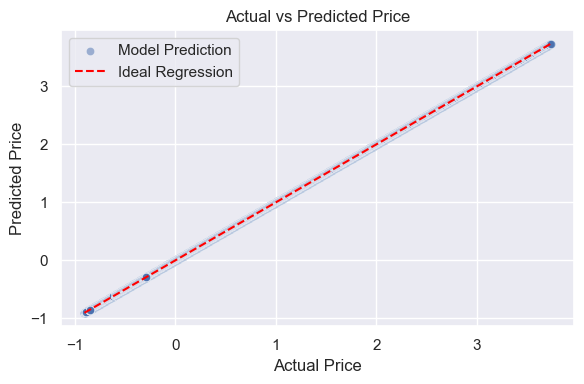

In [32]:
# TODO
# 5. 마지막으로 모델을 평가해봅시다.
# 얻어낸 `theta`와 데이터의 행렬곱을 통하여 예측값인 `y_pred`를 구해보고
# 예측값과 실제값 차이를 나타내는 MSE를 계산해봅시다.
y_pred = X_b @ theta # shape = (m, 1)
mse    = np.mean((y_pred - y) ** 2)

print("파라미터 θ:\n", theta.flatten())
print(f"MSE: {mse:.2f}")
plot_prediction(y_true=y, y_pred=y_pred)

실제로 연구를 진행할 때 MSE가 0이 나오는 완벽한 경우는 찾기가 어렵습니다. 해당 데이터는 연습용 데이터이다보니 최적화가 잘되는 경우입니다.  

보통 MSE만 보고 모델이 얼마나 잘하고 있는지 알 수 있지만,어디까지나 평가 지표는 하나의 숫자로 모델의 성능을 보고 이씩 때문에 _데이터 별 예측상황_을 알기는 어렵습니다_. 따라서 모델 학습 중간, 후에 예측값에 대한 시각화를 진행해보는 것은 중요합니다.

❓ 예측대상인 `price`도 정규화해야할까?

- 선형 회귀의 해(θ)는 타깃 $y$의 스케일에 선형 비례합니다.  
- 정규방정식이나 `np.linalg.lstsq`로 해를 구할 때는 타깃을 스케일링하지 않아도 수학적으로 전혀 문제가 없습니다.  
- 다만  
  - 타깃이 매우 큰 값(예: 수백만 단위)일 경우 컴퓨터 숫자 표현 한계로 인해 드물게 수치 안정성이 조금 떨어질 수 있고  
  - 경사하강법을 함께 사용한다면 타깃 정규화가 학습 속도와 수렴 품질을 개선할 수 있습니다.  
- 실무에서는 최종적으로 원래 단위로 해석하기 위해 예측 후 반드시 역변환(inverse transform)을 적용해야 합니다.  


❓ 절편 (intercept) 항에 1을 채우는 이유는 뭘까?

- 절편 $\theta_0$를 표현하려면 항상 1과 곱해지는 입력 특성이 필요합니다.  
- 입력 행렬 첫 열을 모두 1로 두면 해석이 직관적입니다. 즉  

  $$ \theta_0 \times 1 = \theta_0 $$

  이 되어 θ₀가 순수 절편 역할을 합니다.  

- 만약 다른 상수 \(c\)를 쓰면 예측식이  
  $$ \hat{y} = \theta_0 \times c + \sum_{j=1}^n \theta_j x_j $$
  가 되고, $\theta_0$ 자체가 절편이 아니라 $\theta_0 \times c$가 절편이어서 해석이 복잡해집니다.  
- 관례적으로 1을 사용하면 수식도 간결해지고 수치 조건수(condition number) 악화 없이 안정적입니다.  


## 2.2 최소제곱법(Least Squares)로 해 찾기: `np.linalg.lstsq`

### 2.2.1 정규방정식의 불안정성
선형회귀 문제를 풀 때 흔히 사용하는 방법은 정규방정식  
$$
\theta = \bigl(X_b^\mathsf{T} X_b\bigr)^{-1} X_b^\mathsf{T} y
$$


입니다. 하지만 이 방식은 다음과 같은 한계가 있습니다.

1. 역행렬 계산의 수치적 불안정성  
   - $X_b^\mathsf{T} X_b$가 거의 특이(singular)에 가까워지면 작은 수치 오차에도 해가 크게 출렁입니다.  
   - 고차원·상관관계가 높은(feature들 간에) 데이터일수록 $X_b^\mathsf{T} X_b$의 조건수가 커집니다.
   - 이런 행렬은 아주 작은 계산 오차에도 결과가 크게 흔들려서, 수치적으로 매우 불안정
   - 열들이 겹쳐 있다는 건, 서로 다른 변수처럼 보여도 사실 같은 정보를 담고 있어서 독립적이지 않은 상태
   - 고차원·상관관계가 높은(feature들 간에) 데이터일수록 $X_b^\mathsf{T} X_b$의 조건수가 커집니다.
   
2. 행렬이 완전한 정칙(invertible)이 아닐 때 해를 구할 수 없음  
   - 피처가 많거나 중복될수록 $X_b^\mathsf{T} X_b$가 비가역행렬이 되어 역행렬 계산이 불가능해집니다.

---

### 2.2.2 `np.linalg.lstsq`의 핵심 원리

- 특이값 분해(SVD)를 이용하여 **의사역행렬(pseudoinverse)**을 계산합니다.  
- 의사역행렬 $X_b^+$를 통해 최소제곱 해를 구합니다. (기존 정규방정식의 $\bigl(X_b^\mathsf{T} X_b\bigr)^{-1} X_b^\mathsf{T}$를 대체)
  
$$ \theta = X_b^+\,y $$

- 수치 안정성이 높아 극단적인 피처 스케일 차이, 상관관계 과다 문제를 완화합니다.


### 2.2.3 최소제곱법의 주요 장점
- $X_b^\mathsf{T} X_b$의 역행렬을 직접 구하지 않아도 됨  
- 특이(Singular, 는 거의 특이)한 상황에서도 해를 산출.  
- 잔차(residuals), 랭크(rank), 특이값(singular values)을 함께 반환하여 모델 진단이 가능  

위와 같은 이유로 정규방정식 계산 대신 `np.linalg.lstsq`를 활용하면  
더욱 견고하고 실용적인 선형회귀 해를 얻을 수 있습니다.

- 참고: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html

In [33]:
# TODO: `lstsq`를 이용하여 `theta_lstsq`를 구해주세요.
theta_lstsq, residuals, rank, singular_vals = np.linalg.lstsq(X_b, y, rcond=None)

파라미터 θ:
 [-7.58154162e-16 -1.28091981e-14 -4.49293380e-16 -5.72458747e-17
  1.00000000e+00 -1.10978934e-15 -1.81712284e-16  6.98226199e-17]
MSE: 0.00


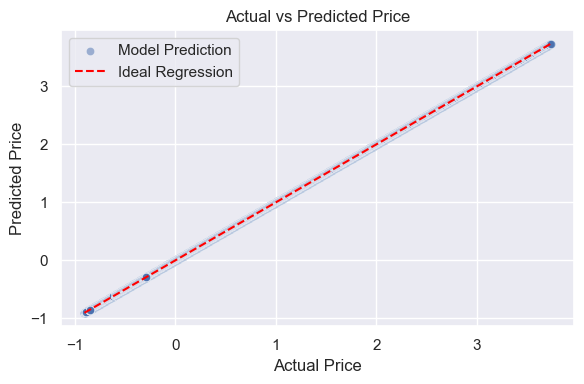

In [34]:
# TODO
# 마지막으로 모델을 평가해봅시다.
# 얻어낸 `theta_lstsq`와 데이터의 행렬곱을 통하여 예측값인 `y_pred`를 구해보고
# 예측값과 실제값 차이를 나타내는 MSE를 계산해봅시다.
y_pred = X_b @ theta_lstsq
mse    = np.mean((y_pred - y)**2)

print("파라미터 θ:\n", theta_lstsq.flatten())
print(f"MSE: {mse:.2f}")
plot_prediction(y_true=y, y_pred=y_pred)

## 2.3 SVD를 이용한 최소제곱 해 구하기

SVD(특이값 분해, Singular Value Decomposition)는 임의의 행렬 $A\in\mathbb{R}^{m\times n}$를  

$$
A = U\,\Sigma\,V^\mathsf{T}  
$$

  
으로 분해하는 기법입니다. 여기서  
- $U\in\mathbb{R}^{m\times r}$와 $V\in\mathbb{R}^{n\times r}$는 직교 행렬 (orthogonal)
- $\Sigma\in\mathbb{R}^{r\times r}$는 특이값을 대각으로 가진 대각 행렬이며 $r=\mathrm{rank}(A)$입니다.  

SVD를 이용하면 최소제곱 해를 닫힌 형식으로 구할 수 있습니다. pseudoinverse $\Sigma^+$를 정의하면  

$$
\Sigma^+_{ii} = \frac{1}{\Sigma_{ii}}\quad(\Sigma_{ii}>0)
$$


이고, 이때  


$$ x^* = A^+ b = V\,\Sigma^+\,U^\mathsf{T} b
$$


로 최소제곱 해 $\min_x\|Ax - b\|_2^2$를 얻게 됩니다.  

`np.linalg.lstsq`와 달리 직접 SVD (`np.linalg.svd`)를 사용하면  
- 특이값 절단(threshold)을 직접 제어할 수 있고  
- $U, \Sigma, V^\mathsf{T}$를 학습이나 시각화용으로 바로 활용할 수 있으며  
- 정규화(regularization)나 저차원 근사(rank-truncated) 해법 설계가 수월해집니다.
- 참고: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html  

In [35]:
# TODO:
# SVD를 수행하여 해를 구해봅시다.

# 1. SVD를 수행하여 U, S, V^T를 구해봅시다.
U, S, Vt = np.linalg.svd(X_b, full_matrices=False)

# 2. 위에서 설명한 수식을 참고하여 Pseudo-inverse S_plus를 구해봅시다.
S_plus = np.diag(1.0 / S)

# 3. 앞서 배운 수식을 참고하여 `theta_svd`를 구해봅시다
theta_svd = Vt.T @ S_plus @ U.T @ y

파라미터 θ:
 [-4.81402028e-15 -3.10168558e-15 -5.14237090e-16 -4.72142941e-16
  1.00000000e+00  5.48172618e-16 -4.05925293e-16  2.60208521e-16]
MSE: 0.00


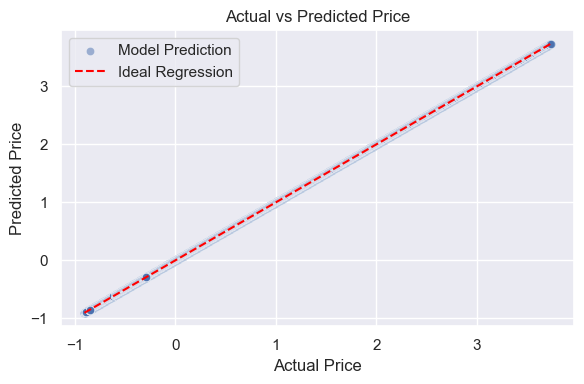

In [36]:
# TODO
# 마지막으로 모델을 평가해봅시다.
# 얻어낸 `theta_svd`와 데이터의 행렬곱을 통하여 예측값인 `y_pred`를 구해보고
# 예측값과 실제값 차이를 나타내는 MSE를 계산해봅시다.
y_pred = X_b @ theta_svd
mse    = np.mean((y_pred - y) ** 2)

print("파라미터 θ:\n", theta_svd.flatten())
print(f"MSE: {mse:.2f}")
plot_prediction(y_true=y, y_pred=y_pred)

# 3. 경사 하강법과 손실 계산

### 3.1 왜 경사 하강법을 사용해야 할까?

선형대수 기반의 닫힌 형식 해법(정규방정식, SVD 등)은 한 번에 해를 구한다는 장점이 있지만,
- $X_b^\mathsf{T}X_b$의 역행렬 계산 또는 전체 행렬 분해가 필요합니다.
- 특성 수($n$)나 데이터 수 ($m$)가 커지면 메모리와 연산량이 **급격히** 증가합니다.  

경사 하강법은 정확한 해를 한 번에 구하기보단,조금씩 내려가며 근사적인 최적의 해를 찾는 방식
- 배치(batch), 미니배치(mini-batch), 온라인(online) 방식으로 데이터를 나누어 처리해 **메모리 제약을 완화**하고 대규모 데이터에 유연하게 대응할 수 있습니다.  
- 정규화 항이나 비선형 손실 함수에도 쉽게 확장 가능해 딥러닝 등 넓은 영역에서 핵심 기법으로 쓰입니다.  


### 3.2 손실 함수(MSE) 계산

모델 예측 $\hat y = X_b\,\theta$와 실제 $y$ 사이의 평균 제곱 오차는 앞선 2.1 정규방정식에서 다룬 손실함수와 동일합니다.
$$
\mathrm{J(\theta)} = \frac{1}{m}\sum_{i=1}^{m}\bigl(\hat y_i - y_i\bigr)^2
$$

학습 반복마다 MSE를 계산해 `loss_history`에 저장하면  
- 수렴 과정을 시각화  
- 학습률 스케줄링 또는 조기 종료(early stopping) 기준  
로 활용할 수 있습니다.  


### 3.3 그래디언트 계산 및 업데이트
손실이 줄어들게 하려면 “θ를 얼마나, 어느 방향으로 바꿔야 할까?”를 알아야 하는데, 그걸 알려주는 게 **그래디언트(gradient)**

선형 회귀 MSE의 파라미터 $\theta$에 대한 그래디언트는  

$$
\nabla_\theta = \frac{2}{m}\,X_b^\mathsf{T}\bigl(X_b\,\theta - y\bigr)
$$


입니다.  

학습률 $\alpha$를 사용한 업데이트 식은  
현재 θ에서 손실이 가장 빠르게 커지는 방향으로 보내기 위해

$$
\theta \leftarrow \theta - \alpha\,\nabla_\theta
$$


로, 기울기가 가리키는 손실 상승 방향의 반대로 이동하면서 손실을 점진적으로 줄여 갑니다.  

- α(alpha) = 학습률(learning rate): 한 번에 얼마나 이동할지
- ∇θ = 기울기 벡터
- θ ← ... = 새로운 가중치로 갱신


100%|██████████| 1000/1000 [00:01<00:00, 938.33it/s]

최종 θ: [-6.66760619e-17  1.37553160e-01 -4.91584831e-03 -5.51089520e-03
  9.32494793e-01 -1.70028629e-02 -2.69295815e-02 -2.96354905e-02]
최종 MSE: 0.000854141507526024


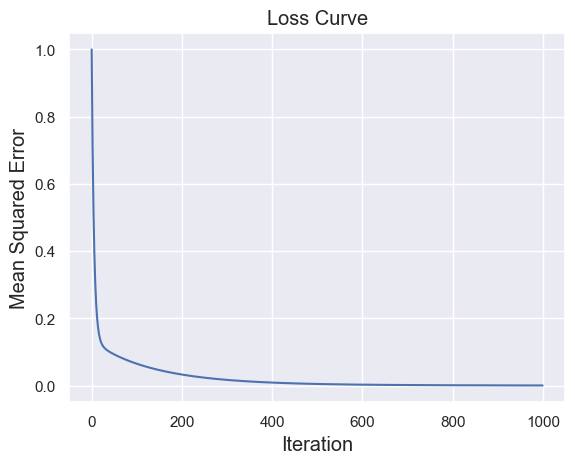

In [37]:
# TODO: None으로 입력된 부분을 요구사항에 맞춰 수정하며 문제를 풀어주세요
from tqdm import tqdm

# 1. 초기파라미터 설정
theta        = np.zeros(n+1)
alpha        = 0.01
iterations   = 1000
loss_history = []

# TODO:
# 2. 경사하강법 루프를 만들어봅시다.
# 정해진 iterations 수만큼 루프를 만들어줍니다.
for i in tqdm(range(iterations)):
    # 현재 매개변수 `theta`에 의한 예측값 `y_pred`를 계산합니다.
    y_pred     = (X_b @ theta).flatten()

    # 예측해야하는 실제값 `y`와의 차 `error`를 계산하고,
    # `error`를 기반으로 `mse`를 계산해주세요.
    error      = y_pred - y
    mse        = np.mean(error**2)
    loss_history.append(mse)

    # 위에서 공부한 식을 토대로 `gradient`를 계산해주세요.
    gradient   = (2/m) * X_b.T @ error

    # 얻어낸 `gradient`를 기반으로 `theta`를 업데이트해주세요.
    theta      -= alpha * gradient

# 3. 학습 결과를 시각화해봅시다.
print("최종 θ:", theta.flatten())
print("최종 MSE:", loss_history[-1])

plt.plot(loss_history)
plt.xlabel("Iteration", size="large")
plt.ylabel("Mean Squared Error", size="large")
plt.title("Loss Curve", size="large")
plt.show()

여기서 고민할만한 점이 많습니다.   
❓ **초기설정값, 저렇게하는게 맞나요...?**
  - Iterations, 학습률 (alpha), 초기매개변수값 등 모두 저렇게 초기화하는게 정답일까요?
  - 사실 정해진 값은 없습니다. 어느 정도 경험으로부터 초기설정되는 것들이 많습니다. 특히 학습률의 경우 학습에서 사실상 가장 큰 영향을 준다고 해도 과언이 아닐 정도로 (값에 따라 수렴하지 않는 경우가 많아서) 중요합니다. 그렇기 때문에 여러번 많은 실험을 통해 좋은 값을 찾아주는 것이 좋습니다.
  - Iteration이나 학습률과 같이 _학습되지 않는_ 값들을 우리는 **초매개변수 (Hyperparameters)**라고 부릅니다.

❓ **iterations에 도달하기 전에 MSE가 도달할 수도 있지 않나...?**
  - 맞습니다. 중간에 트리거를 걸어 목표 손실함수 값에 도달했을 때 루프를 깨고 학습을 멈출 수 있습니다.

❓ **미분을 통한 업데이트, 최선인가?**
  - 오늘 배운 배치 경사 하강법은 평균 제곱 오차를 미분해 전역 최적해로 수렴 가능한 방법입니다. 하지만  1차 도함수만 이용하기 때문에, 학습률 설정이 부적절하면 진동하거나 느리게 수렴할 수 있습니다.  
  - 이런 한계를 보완하기 위해 모멘텀, RMSProp, Adam 같은 고급 최적화 기법을 활용하면 더 빠르고 안정적으로 학습할 수 있습니다. 과제에서 가볍게 구현해봅시다.

❓ **학습할 때마다 이 코드를 매번 새로 채우나요?**
  - 실무에서는 직접 경사 하강법 코드를 매번 작성하기보다, `scikit-learn`, `TensorFlow`, `PyTorch` 같은 라이브러리의 최적화 함수를 사용합니다.  
  - 이들 프레임워크는 학습 루프, 손실 추적, 조기 종료, 다양한 옵티마이저를 추상화해 줍니다.
  - 학습 원리를 이해하기 위해 초반에는 수작업 구현이 유익하지만, 규모가 커지면 라이브러리 활용이 생산성을 크게 높입니다.  

❓ **데이터가 많을 때도 가능할까?**
  - 배치 경사 하강법은 한 번에 전체 데이터(m×n)를 곱연산하기 때문에 매우 큰 데이터셋에서는 메모리와 연산량이 부담이 됩니다.  
  - 이를 해결하기 위해 보통 미니배치 경사 하강법(mini-batch GD)이나 확률적 경사 하강법(SGD)을 사용해 한 번에 일부 샘플만 처리합니다.  
  - 또한 분산 처리(distributed training)나 GPU 가속을 통해 수십만, 수백만 개의 데이터도 효율적으로 학습할 수 있습니다.  

❓ **새로운 데이터에 대해서도 잘되는게 맞나?**
  - 잘 생각해보면 최적화를 현재 가지고 있는 모든 데이터에 대해 진행했습니다. 만약 새로운 다이아몬드에 대한 정보가 들어왔을 때 우리는 해당 데이터에 대해서도 최적화한 매개변수가 잘 예측할 수 있을까요?
  - 이에 대처하기 위해서는 보유하고 있는 모든 데이터를 최적화에 사용하는 것이 아니라 일부만을 사용하여 학습을 진행한 후, 따로 빼둔 데이터에 대해 검증을 진행합니다. 학습에 사용한 데이터는 보통 Train dataset, 검증에 사용한 데이터셋은 Validation dataset이라 부릅니다.
  - 이에 대한 이론적인 내용과 실습은 첫 번째 챕터에서 본격적으로 배운 후 진행해볼 예정입니다 :)

### 🧑‍💻 **실습**: 알고리즘 보완하기

위에서 나온 질문들의 해답을 반영해 보완해봅시다. 모아서 함수로 만들어서 진행해봅시다.

1. **Early Stopping**: MSE가 이미 0, 혹은 0에 가까운 값에 수렴했다면 굳이 학습을 더 진행할 필요가 없습니다. 따라서 일정 MSE 이하로 떨어졌을 경우 루프를 깨고 학습을 마무리하는 코드를 추가해봅시다.
2. **Mini-batch training**: 데이터가 너무 많을 경우 손실 계산과 미분 계산에 있어 연산량이 많아져 계산이 어려운 경우가 있습니다. 이를 보완한 것이 Mini-batch Gradient Descent로 전체 데이터에 대한 미분이 아닌 일부 데이터만을 이용한 미분을 통해 매개변수를 업데이트할 수 있습니다. 이 _일부 데이터_를 `batch`라고 표현합니다. `batch_size`를 지정하여 나눠서 업데이트를 진행해봅시다.
  - 참고: https://medium.com/analytics-vidhya/gradient-descent-vs-stochastic-gd-vs-mini-batch-sgd-fbd3a2cb4ba4
3. **Gradient Accumulation**은 메모리나 하드웨어 제약으로 한 번에 큰 배치 크기를 사용할 수 없을 때, 작은 미니배치들의 기울기(gradient)를 모아서(accumulate) 한 번에 파라미터를 갱신하는 기법입니다.  
  - 보통 `batch_size`를 줄이면 메모리는 절약되지만, 너무 자주 업데이트가 일어나 노이즈가 커지고 통신 오버헤드가 증가합니다.  
  - `accumulate_steps`만큼의 미니배치 기울기를 더해 두었다가, 그 누적된 기울기를 한 번에 반영함으로써  
    - 효과적으론 큰 `effective_batch_size = batch_size × accumulate_steps`를 사용  
    - 메모리 사용량은 낮추면서도 업데이트 빈도와 안정성 사이 균형을 맞출 수 있습니다.  
  - 분산 학습 환경에서는 각 워커(worker)마다 미니배치 기울기를 모은 뒤, 중앙 서버에 한 번 전송해 통신량을 크게 줄이는 용도로도 쓰입니다.



In [44]:
# 중간중간 TODO 부분을 채우며 코드를 완성시켜주세요 :)
def train_linear_regression_sequential(
    X_b, y,
    alpha=0.01,
    epochs=100,
    tol=None,
    batch_size=None,
    accumulate_steps=1,
):
    """
    Shuffling 없이 순차적으로 미니배치를 구성하는 선형 회귀 학습 함수
    X: (m, n) 입력 피처
    y: (m,) 타깃
    alpha: 학습률
    epochs: 전체 반복 횟수
    tol: MSE 기준 조기 종료 임계값
    batch_size: 미니배치 크기 (None이면 전체 배치)
    accumulate_steps: Gradient Accumulation할 배치 수
    """
    m, n = X_b.shape
    theta = np.zeros(n) # 파라미터 초기화
    history = []

    # 이렇게 설정하면 batch_size를 주지 않았을 때 전체 데이터 미분을 사용하게 됩니다
    bs = batch_size or m

    for epoch in range(1, epochs + 1):
        grad_accum = np.zeros_like(theta)
        accum_count = 0

        # 순차적 미니배치 학습
        for start in range(0, m, bs):
            # TODO: Mini-batch 구성하기
            # 현재 batch 내의 index 시작 위치를 나타내는 `start` 변수를 기반으로
            # batch를 구성해줍니다.
            end = min(start + bs, m)
            X_batch = X_b[start:end]
            y_batch = y[start:end]

            # TODO: Calculating Gradients on mini-batch
            # 현재 batch의 prediction을 계산하기
            # prediction과 ground truth 사이 오차 계산하기
            # 오차를 기반으로 미분 계산하기
            y_pred = X_batch.dot(theta)
            error = y_pred - y_batch
            grad  = (2 / X_batch.shape[0]) * X_batch.T.dot(error)

            grad_accum += grad
            accum_count += 1
            # 누적된 gradient를 기준으로 업데이트
            if accum_count == accumulate_steps or end == m:
                theta -= alpha * (grad_accum / accum_count)
                # TODO: 업데이트 후에는 `grad_acuum`과 `accum_count`를 초기화해줍니다.
                grad_accum[:] = 0
                accum_count = 0
                
        # TODO: 전체 MSE 계산 및 기록
        # batch 별로 MSE를 계산할 수 있지만, 이는 전체 데이터에 대한 것이 아니기 때문에
        # 누적된 전체 데이터의 MSE를 계산해줍니다.
        # 이는 batch loop를 돌 때 MSE 결과를 저장하여 루프 후 평균을 내거나
        # 전체 데이터에 대해 다시 추론을 하는 방식으로 진행할 수 있습니다.
        # `print`문을 통하여 중간중간 학습결과를 계속 확인하는 것이 중요합니다.
        mse = np.mean((X_b.dot(theta) - y) ** 2)
        history.append(mse)
        print(f"Epoch {epoch:3d}/{epochs}    MSE: {mse:.6f}")

        # TODO: Early stopping
        # 현재 MSE과 tol을 비교하여 학습을 진행하거나 Loop를 깹니다
        if tol is not None and mse < tol:
            print(f"-> Early stopping at epoch {epoch}, MSE={mse:.6f}")
            break

    return theta, history

In [45]:
theta_est, loss_hist = train_linear_regression_sequential(
    X_b, y,
    alpha=0.01,
    epochs=100,
    tol=1e-4,
    batch_size=32,
    accumulate_steps=2
)
print("추정된 θ:", theta_est)

Epoch   1/100    MSE: 0.011780
Epoch   2/100    MSE: 0.001087
Epoch   3/100    MSE: 0.000188
Epoch   4/100    MSE: 0.000063
-> Early stopping at epoch 4, MSE=0.000063
추정된 θ: [-2.01753996e-03 -5.94139703e-03  1.68627498e-03 -8.50616605e-04
  9.89263082e-01  4.42230174e-02 -1.57787694e-02 -1.28863573e-02]


### 🧑‍💻 **실습**: 초기값 변경해보기

현재 설정된 초매개변수는 학습이 잘되나요? 값을 변경했을 때 현재 학습이 어떻게 될까요? `alpha` 변수를 0.01이 아닌 0.05, 1.0 혹은 1e-5로 변경하여 학습을 한 번 진행해보세요. 결과가 어떻게 변할까요?

# 마치며 ...
오늘 다루지 않았으나, 추후에 다른 실습에서 다뤄볼 보완점은 다음과 같습니다.   
1. **Grid Search**: 여러 가지 초매개변수를 수동으로 바꿔보면서 실험하는 것은 상당히 불쾌한 작업입니다. 이를 조금 더 자동화할 수 있도록 만들어주는 라이브러리가 있는데 과제에서 다뤄보도록 하겠습니다.
2. **scikit-learn, pytorch**: 우리가 작성한 이 모든 일련의 과정을 High-level Framework인 scikit-learn이나 pytorch에서는 더 간단하게 수행이 가능합니다. 이 또한 추후에 다뤄볼 예정입니다.
3. **Different optimiztaion methods**: 오늘 배운 최적화 방법은 가장 기초적인 최적화 방법입니다. 간단하지만 보다 더 쉽게 수렴에 유용한 최적화 방법들은 과제에서 다뤄봅시다.
4. **Data Split**: 앞서 언급했듯, 모든 데이터를 학습에 사용하면 문제가 생깁니다. 이를 나눠주는 방법에 대해서도 추후에 다뤄볼 예정입니다.